# Libraries

In [36]:
import gzip
import pandas as pd
import sweetviz as sv
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
from prophet import Prophet

# Input Data

In [37]:
folder_path = '..\Data\mimic_iv_ed_2_2\ed\edstays.csv'
dataset = pd.read_csv(folder_path)
dataset.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED


# Parameters

In [38]:
year_ = 2181

In [39]:
data = dataset.copy(deep=True)

In [40]:
data['Date'] = pd.to_datetime(data['intime']).dt.date
data['Year'] = pd.to_datetime(data['intime']).dt.year
data.head()


,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,Date,Year
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,2180-05-06,2180
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,2180-06-26,2180
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,2180-08-05,2180
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,2180-07-22,2180
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,2180-07-23,2180


In [41]:
## Filter Out the required Year
year_df = data[data.Year==year_]
year_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,Date,Year
12,10000117,22927623.0,32642808,2181-11-14 21:51:00,2181-11-15 02:06:42,F,WHITE,WALK IN,ADMITTED,2181-11-14,2181
191,10003299,29323205.0,32908139,2181-10-22 11:46:00,2181-10-22 19:09:15,F,BLACK/AFRICAN AMERICAN,AMBULANCE,ADMITTED,2181-10-22,2181
334,10006972,NaN,39055566,2181-06-25 03:18:00,2181-06-25 10:31:00,F,OTHER,AMBULANCE,HOME,2181-06-25,2181
543,10011607,NaN,37301092,2181-05-12 15:26:00,2181-05-12 21:06:00,F,HISPANIC OR LATINO,AMBULANCE,HOME,2181-05-12,2181
632,10013653,NaN,34442203,2181-05-29 11:24:00,2181-05-29 16:15:00,M,OTHER,WALK IN,HOME,2181-05-29,2181


# Convert to Daily Data

In [42]:
daily_counts = year_df.groupby('Date').size().reset_index(name='Admissions Count')
display(daily_counts)

,Date,Admissions Count
0,2181-01-01,17
1,2181-01-02,12
2,2181-01-03,13
3,2181-01-04,9
4,2181-01-05,13
...,...,...
360,2181-12-27,5
361,2181-12-28,16
362,2181-12-29,14
363,2181-12-30,14


# Introduce Seasonality

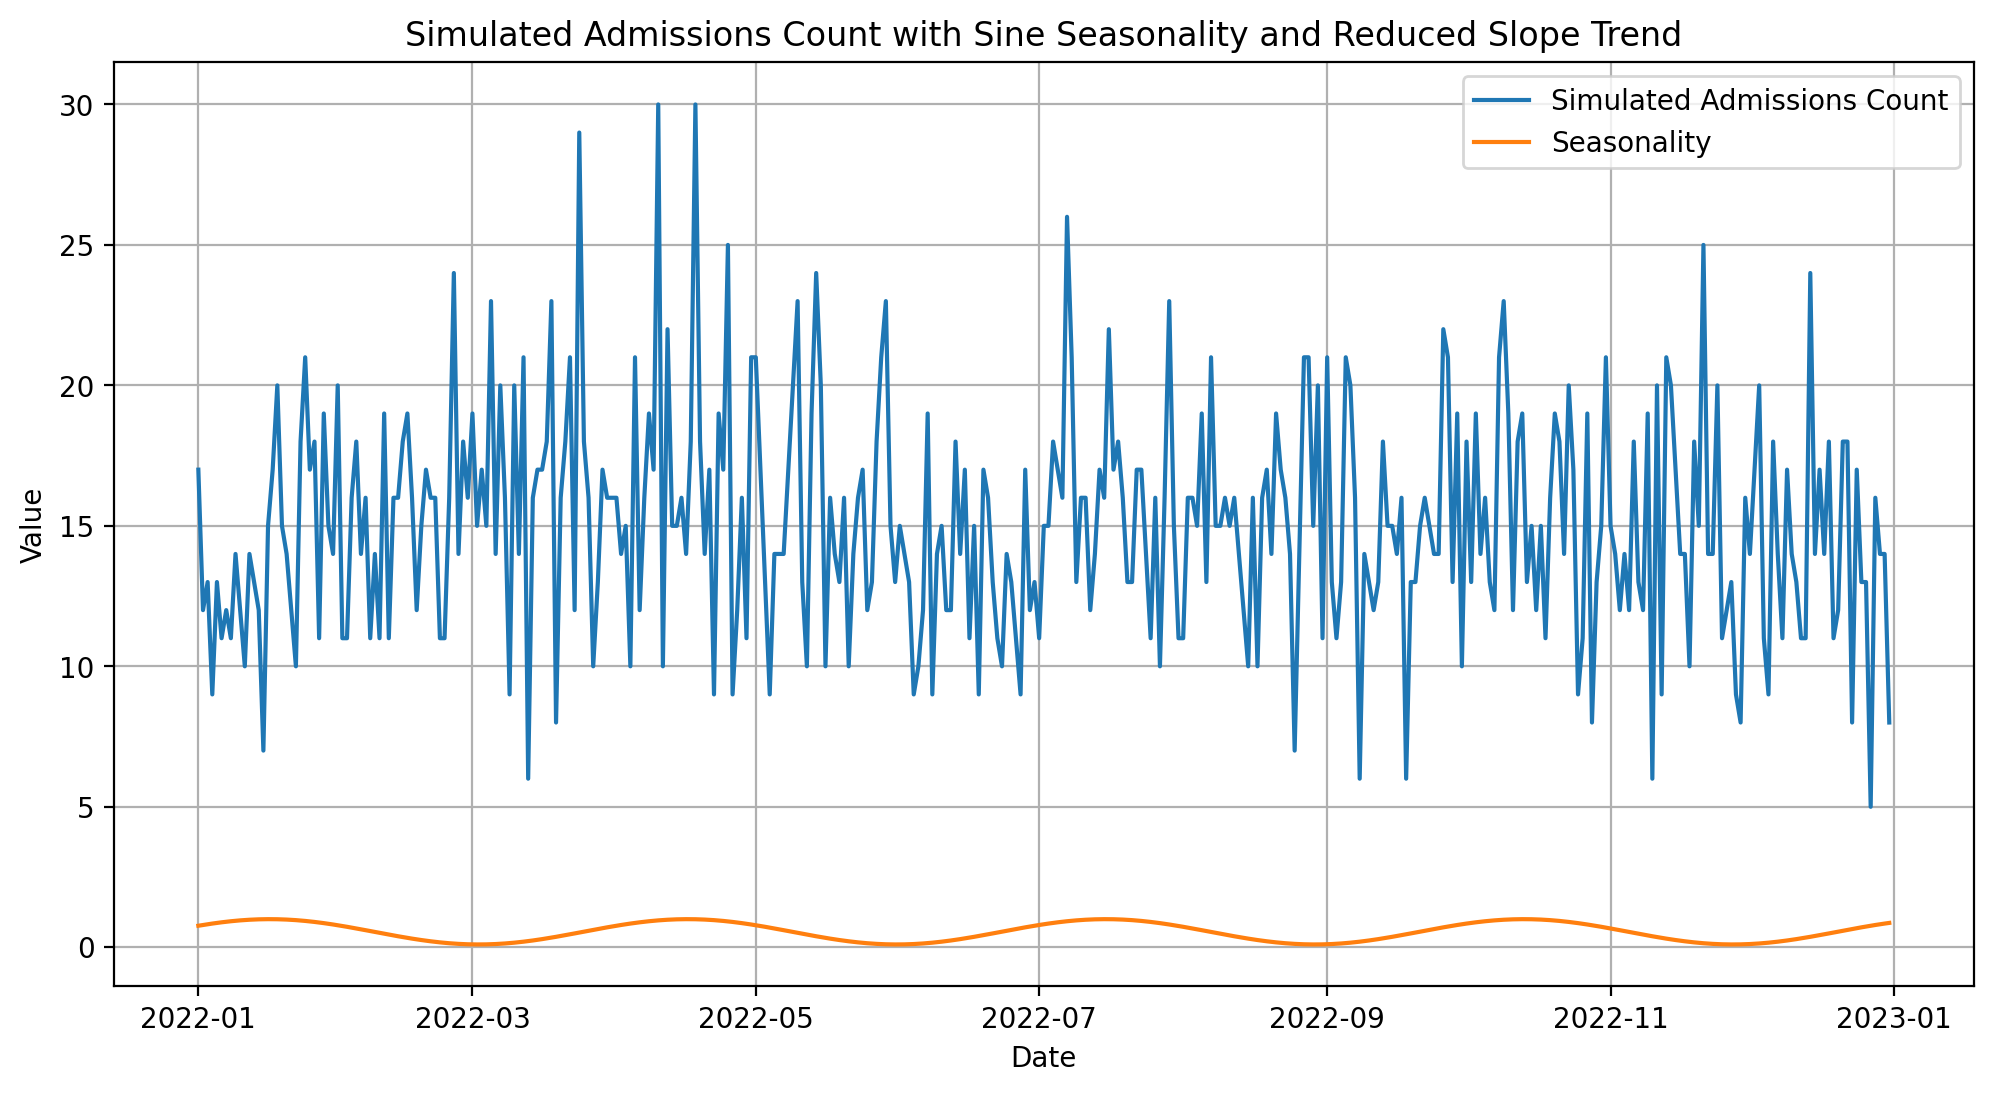

In [43]:
## Get The Date Range
date_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')

# Adjust the amplitude and phase of the sine wave
amplitude = 0.45   # Adjust the amplitude to fit the desired range (0.1 to 1)
phase = 0.5         # Adjust the phase as needed

# Generate a sine wave with the desired parameters
sin_seasonality = amplitude * np.sin(2 * np.pi * np.arange(len(date_range)) / 90 + phase) + 0.55  # Shifted to range from 0.1 to 1

# Create a new DataFrame with the simulated data
simulated_data = pd.DataFrame({
    'Date': date_range,
    'Admissions Count': daily_counts['Admissions Count'],
    'Seasonality': sin_seasonality
#     'Trend': trend
})

# Plot the simulated data
plt.figure(figsize=(12, 6))
plt.plot(simulated_data['Date'], simulated_data['Admissions Count'], label='Simulated Admissions Count')
plt.plot(simulated_data['Date'], simulated_data['Seasonality'], label='Seasonality')
# plt.plot(simulated_data['Date'], simulated_data['Trend'], label='Trend')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Simulated Admissions Count with Sine Seasonality and Reduced Slope Trend')
plt.legend()
plt.grid(True)
plt.show()
# display(simulated_data)

In [44]:
simulated_data['Seasonality'].median()

0.5550884058076105

In [45]:
simulated_data['Seasonality'].min(), simulated_data['Seasonality'].max()

(0.10012529718217289, 0.9998747028178272)

In [46]:
simulated_data['Seasonal Count'] = round(simulated_data['Admissions Count']* simulated_data['Seasonality'])
simulated_data.tail()

,Date,Admissions Count,Seasonality,Seasonal Count
360,2022-12-27,5,0.765741,4.0
361,2022-12-28,16,0.792764,13.0
362,2022-12-29,14,0.818603,11.0
363,2022-12-30,14,0.843134,12.0
364,2022-12-31,8,0.866237,7.0


In [47]:
scaling_factor = 139781
total_sum_count = simulated_data['Seasonal Count'].sum()
scaling_factor_dataset = scaling_factor / total_sum_count
scaling_factor_dataset

45.45723577235773

In [48]:
simulated_data['scaled_count'] = round(simulated_data['Seasonal Count'] * round(scaling_factor_dataset))
simulated_data.reset_index(inplace=True, drop=True)
simulated_data['Seasonality'] = sin_seasonality
simulated_data#.head()

,Date,Admissions Count,Seasonality,Seasonal Count,scaled_count
0,2022-01-01,17,0.765741,13.0,585.0
1,2022-01-02,12,0.792764,10.0,450.0
2,2022-01-03,13,0.818603,11.0,495.0
3,2022-01-04,9,0.843134,8.0,360.0
4,2022-01-05,13,0.866237,11.0,495.0
...,...,...,...,...,...
360,2022-12-27,5,0.765741,4.0,180.0
361,2022-12-28,16,0.792764,13.0,585.0
362,2022-12-29,14,0.818603,11.0,495.0
363,2022-12-30,14,0.843134,12.0,540.0


In [49]:
simulated_data['scaled_count'].sum()

138375.0

In [50]:
final_df = simulated_data.copy(deep=True)
final_df

,Date,Admissions Count,Seasonality,Seasonal Count,scaled_count
0,2022-01-01,17,0.765741,13.0,585.0
1,2022-01-02,12,0.792764,10.0,450.0
2,2022-01-03,13,0.818603,11.0,495.0
3,2022-01-04,9,0.843134,8.0,360.0
4,2022-01-05,13,0.866237,11.0,495.0
...,...,...,...,...,...
360,2022-12-27,5,0.765741,4.0,180.0
361,2022-12-28,16,0.792764,13.0,585.0
362,2022-12-29,14,0.818603,11.0,495.0
363,2022-12-30,14,0.843134,12.0,540.0


In [51]:
final_df['scaled_count'].min()

45.0

# Plot

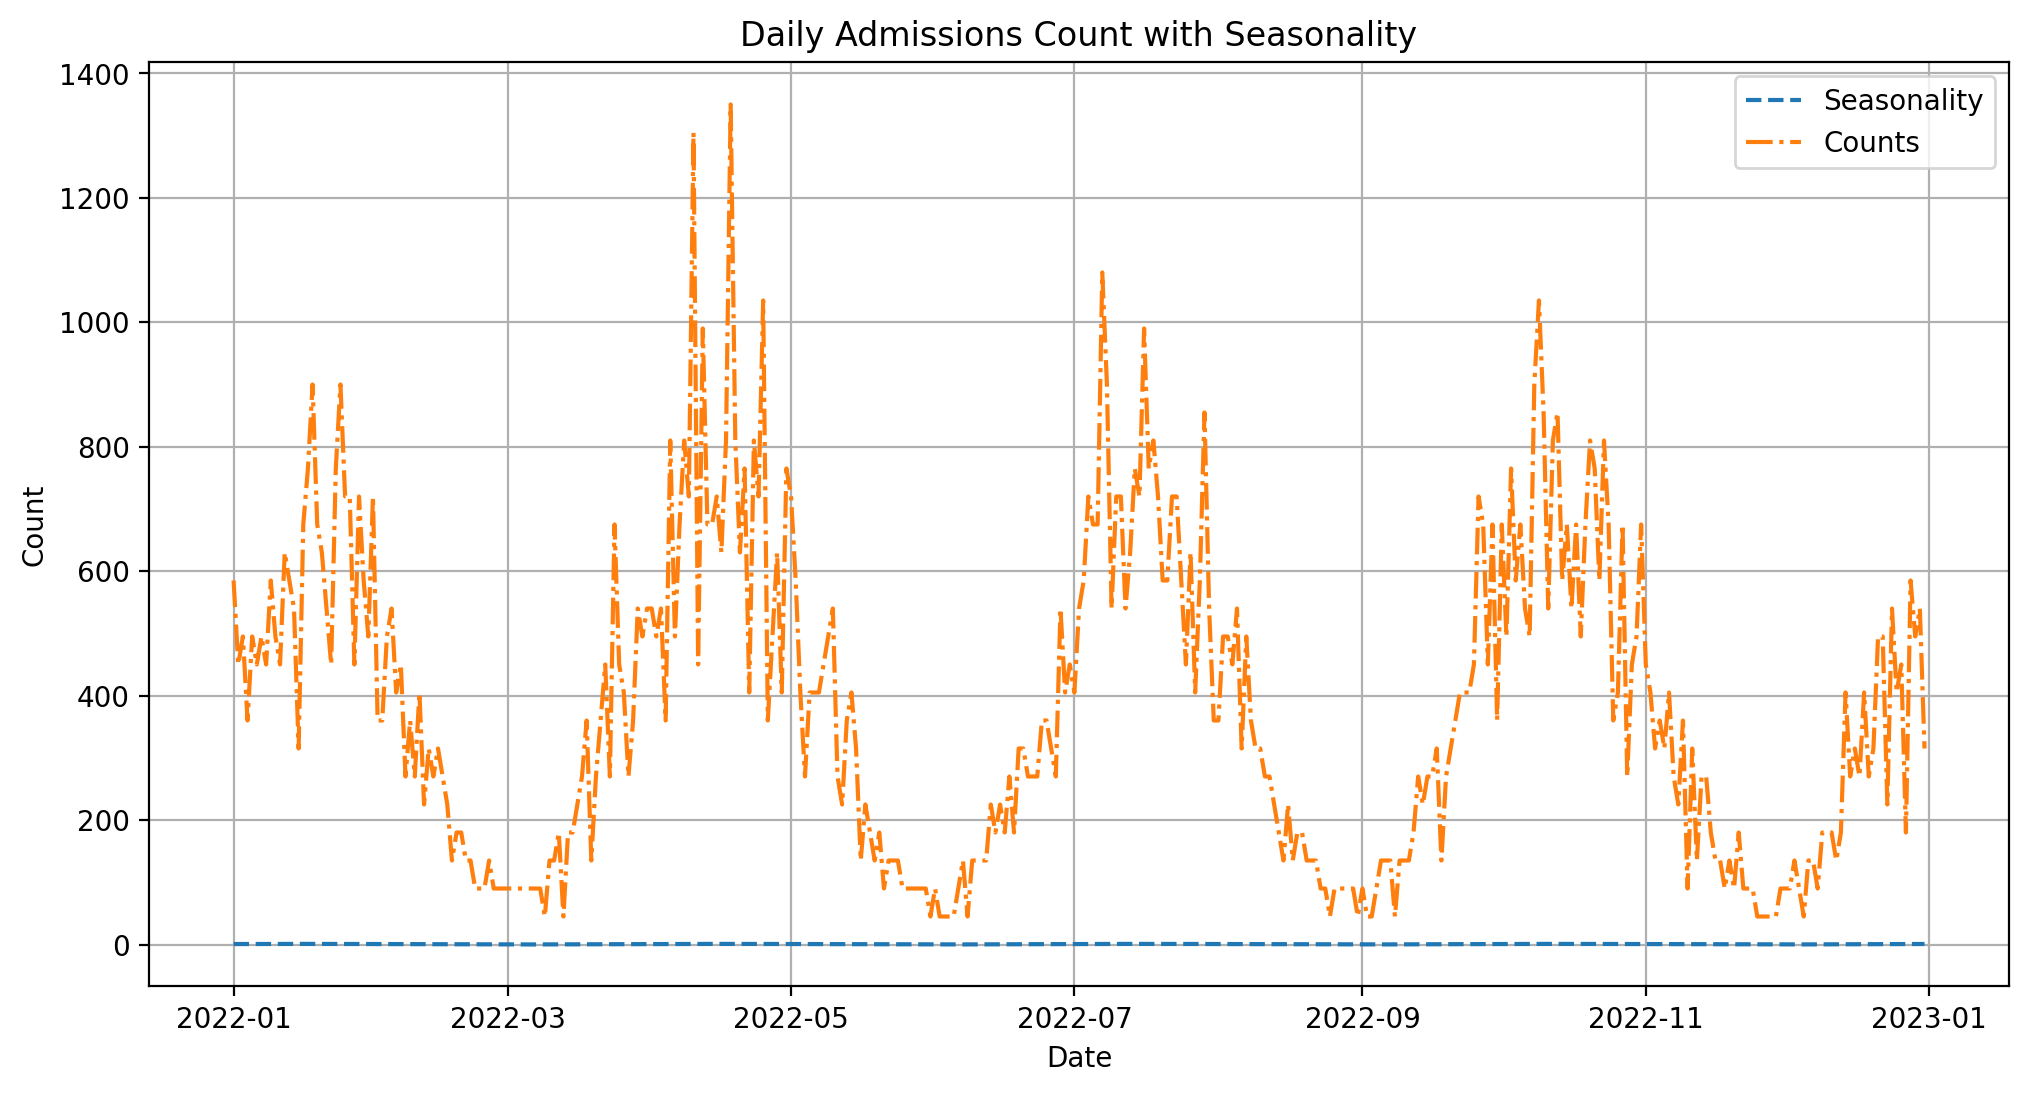

In [52]:
import matplotlib.pyplot as plt

# Plot the daily admission counts and seasonality
plt.figure(figsize=(12, 6))
# plt.plot(daily_counts['Date'], daily_counts['Admissions Count'], label='Admissions Count')
plt.plot(final_df['Date'], final_df['Seasonality'], label='Seasonality', linestyle='--')
plt.plot(final_df['Date'], final_df['scaled_count'], label='Counts', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Admissions Count with Seasonality')
plt.legend()
plt.grid(True)
plt.show()


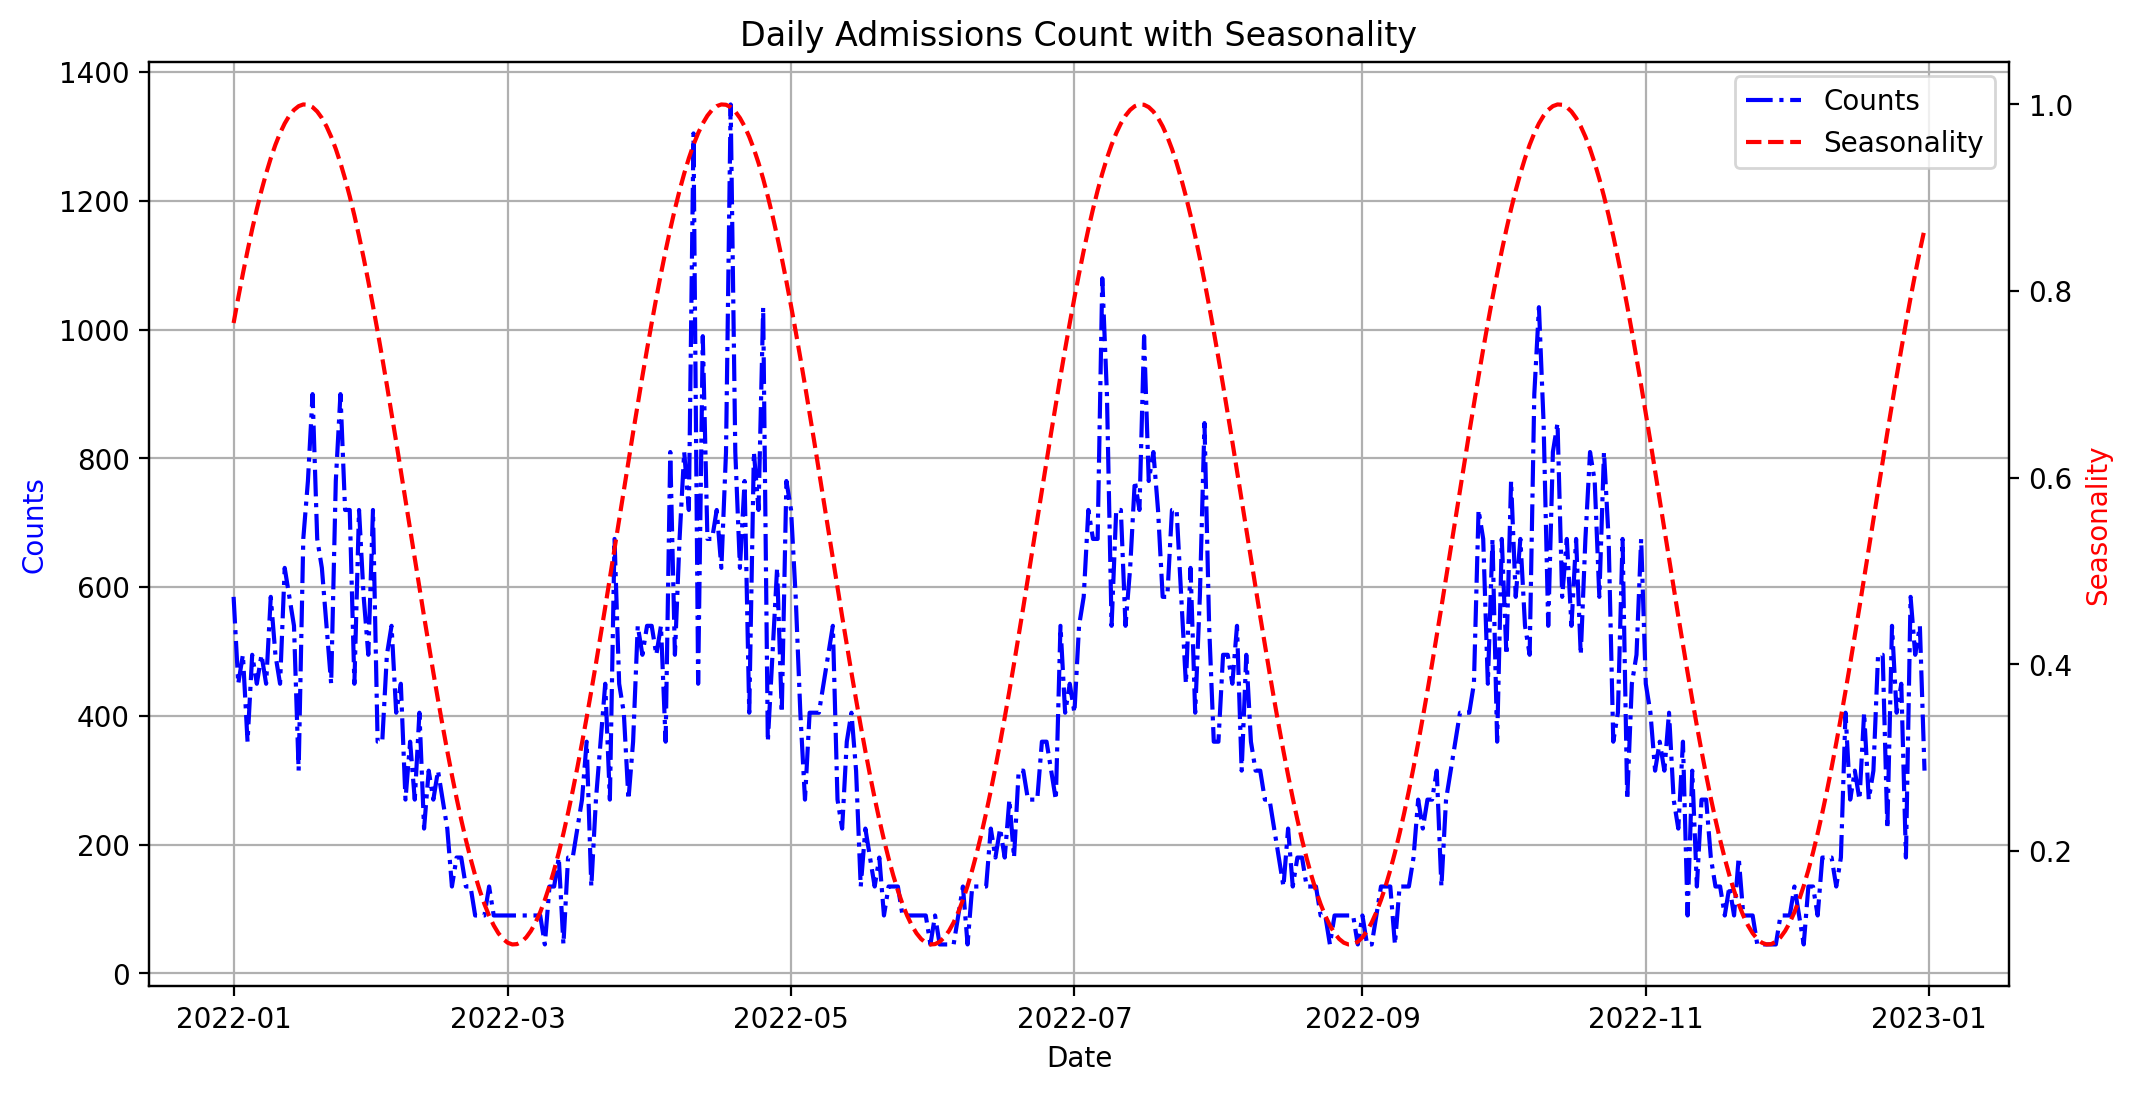

In [53]:

# Create a figure and axis for the primary Y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset with the primary Y-axis
ax1.plot(final_df['Date'], final_df['scaled_count'], label='Counts', linestyle='-.', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Counts', color='b')
ax1.grid(True)

# Create a secondary Y-axis that shares the same X-axis
ax2 = ax1.twinx()

# Plot the second dataset with the secondary Y-axis
ax2.plot(final_df['Date'], final_df['Seasonality'], label='Seasonality', linestyle='--', color='r')
ax2.set_ylabel('Seasonality', color='r')

# Add legends for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Set the title
plt.title('Daily Admissions Count with Seasonality')

plt.show()


In [54]:
final_df.head()

,Date,Admissions Count,Seasonality,Seasonal Count,scaled_count
0,2022-01-01,17,0.765741,13.0,585.0
1,2022-01-02,12,0.792764,10.0,450.0
2,2022-01-03,13,0.818603,11.0,495.0
3,2022-01-04,9,0.843134,8.0,360.0
4,2022-01-05,13,0.866237,11.0,495.0


In [55]:
final_df['Date'] = final_df['Date'].apply(lambda x: x.replace(year=2021))
final_df.head()

,Date,Admissions Count,Seasonality,Seasonal Count,scaled_count
0,2021-01-01,17,0.765741,13.0,585.0
1,2021-01-02,12,0.792764,10.0,450.0
2,2021-01-03,13,0.818603,11.0,495.0
3,2021-01-04,9,0.843134,8.0,360.0
4,2021-01-05,13,0.866237,11.0,495.0


In [56]:
final_df.scaled_count.min(), final_df.scaled_count.max()

(45.0, 1350.0)

In [57]:
distributed_data = final_df.copy(deep=True)

# Data Generator

In [58]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set random seed for reproducibility
random.seed(50)
np.random.seed(50)


# Create a date range for two years
date_range = distributed_data.Date.tolist()

# Initialize empty lists to store data
data = {'Date_Time_Admission': [], 'Patient_ID': [], 'Stay_ID': [], 'Gender': [], 'Mode_of_Arrival': [],
        'Discharge_Time': [], 'Disposition': []}


# patients list
patient_list = []
# Simulate data for each day in the date range
for date in date_range:
    num_patients = int(distributed_data[distributed_data.Date == date]['scaled_count'].values[0])  # Number of patients for the day
    for _ in range(num_patients):
        # Generate patient information
        patient_id = 'P'+str(random.randint(1000, 9999))
        ## If patient already visted the hospital, get the same gender
        if patient_id in patient_list:
            gender = data['Gender'][data['Patient_ID'].index(patient_id)]
        else:
            gender = random.choice(['Male', 'Female'])
            
        patient_list.append(patient_id)
        stay_id = 'A'+str(random.randint(10000, 99999))
        
        mode_of_arrival = random.choice(['Ambulance', 'Own Vehicle', 'Walk In', 'Other'])
        
#         time_of_day = 'Morning' if 6 <= date.hour < 12 else \
#                      'Afternoon' if 12 <= date.hour < 18 else \
#                      'Evening' if 18 <= date.hour < 24 else 'Night'
        
        in_time = pd.to_datetime(date)+ timedelta(minutes=random.randint(0, 1440))
        discharge_time = in_time + timedelta(minutes=random.randint(120, 480))
        disposition = random.choice(['HOME', 'ADMITTED', 'ELOPED', 'TRANSFER', 'LEFT WITHOUT BEING SEEN', 
                                     'OTHER', 'LEFT AGAINST MEDICAL ADVICE', 'EXPIRED'])

        # Append data to the lists
        data['Date_Time_Admission'].append(in_time)
        data['Patient_ID'].append(patient_id)
        data['Stay_ID'].append(stay_id)
        data['Gender'].append(gender)
        data['Mode_of_Arrival'].append(mode_of_arrival)
        data['Discharge_Time'].append(discharge_time)
        data['Disposition'].append(disposition)
        

# Create a DataFrame from the data
generated_data = pd.DataFrame(data)

generated_data['Date'] = generated_data['Date_Time_Admission'].dt.date 
generated_data['Date'] = generated_data['Date'].astype(str)
generated_data.sort_values(by='Date_Time_Admission',inplace=True)
generated_data.head()

,Date_Time_Admission,Patient_ID,Stay_ID,Gender,Mode_of_Arrival,Discharge_Time,Disposition,Date
87,2021-01-01 00:04:00,P7357,A78543,Female,Ambulance,2021-01-01 02:28:00,ADMITTED,2021-01-01
177,2021-01-01 00:06:00,P3219,A46926,Female,Own Vehicle,2021-01-01 02:46:00,EXPIRED,2021-01-01
240,2021-01-01 00:07:00,P6034,A53564,Female,Walk In,2021-01-01 06:59:00,LEFT WITHOUT BEING SEEN,2021-01-01
274,2021-01-01 00:10:00,P8147,A79688,Male,Ambulance,2021-01-01 05:23:00,LEFT AGAINST MEDICAL ADVICE,2021-01-01
357,2021-01-01 00:10:00,P3305,A66966,Male,Other,2021-01-01 07:22:00,LEFT AGAINST MEDICAL ADVICE,2021-01-01


In [69]:
df_g

2021-01-01    585
2021-01-02    450
2021-01-03    495
2021-01-04    360
2021-01-05    495
             ... 
2021-12-27    182
2021-12-28    585
2021-12-29    493
2021-12-30    542
2021-12-31    315
Name: Date_Time_Admission, Length: 365, dtype: int64

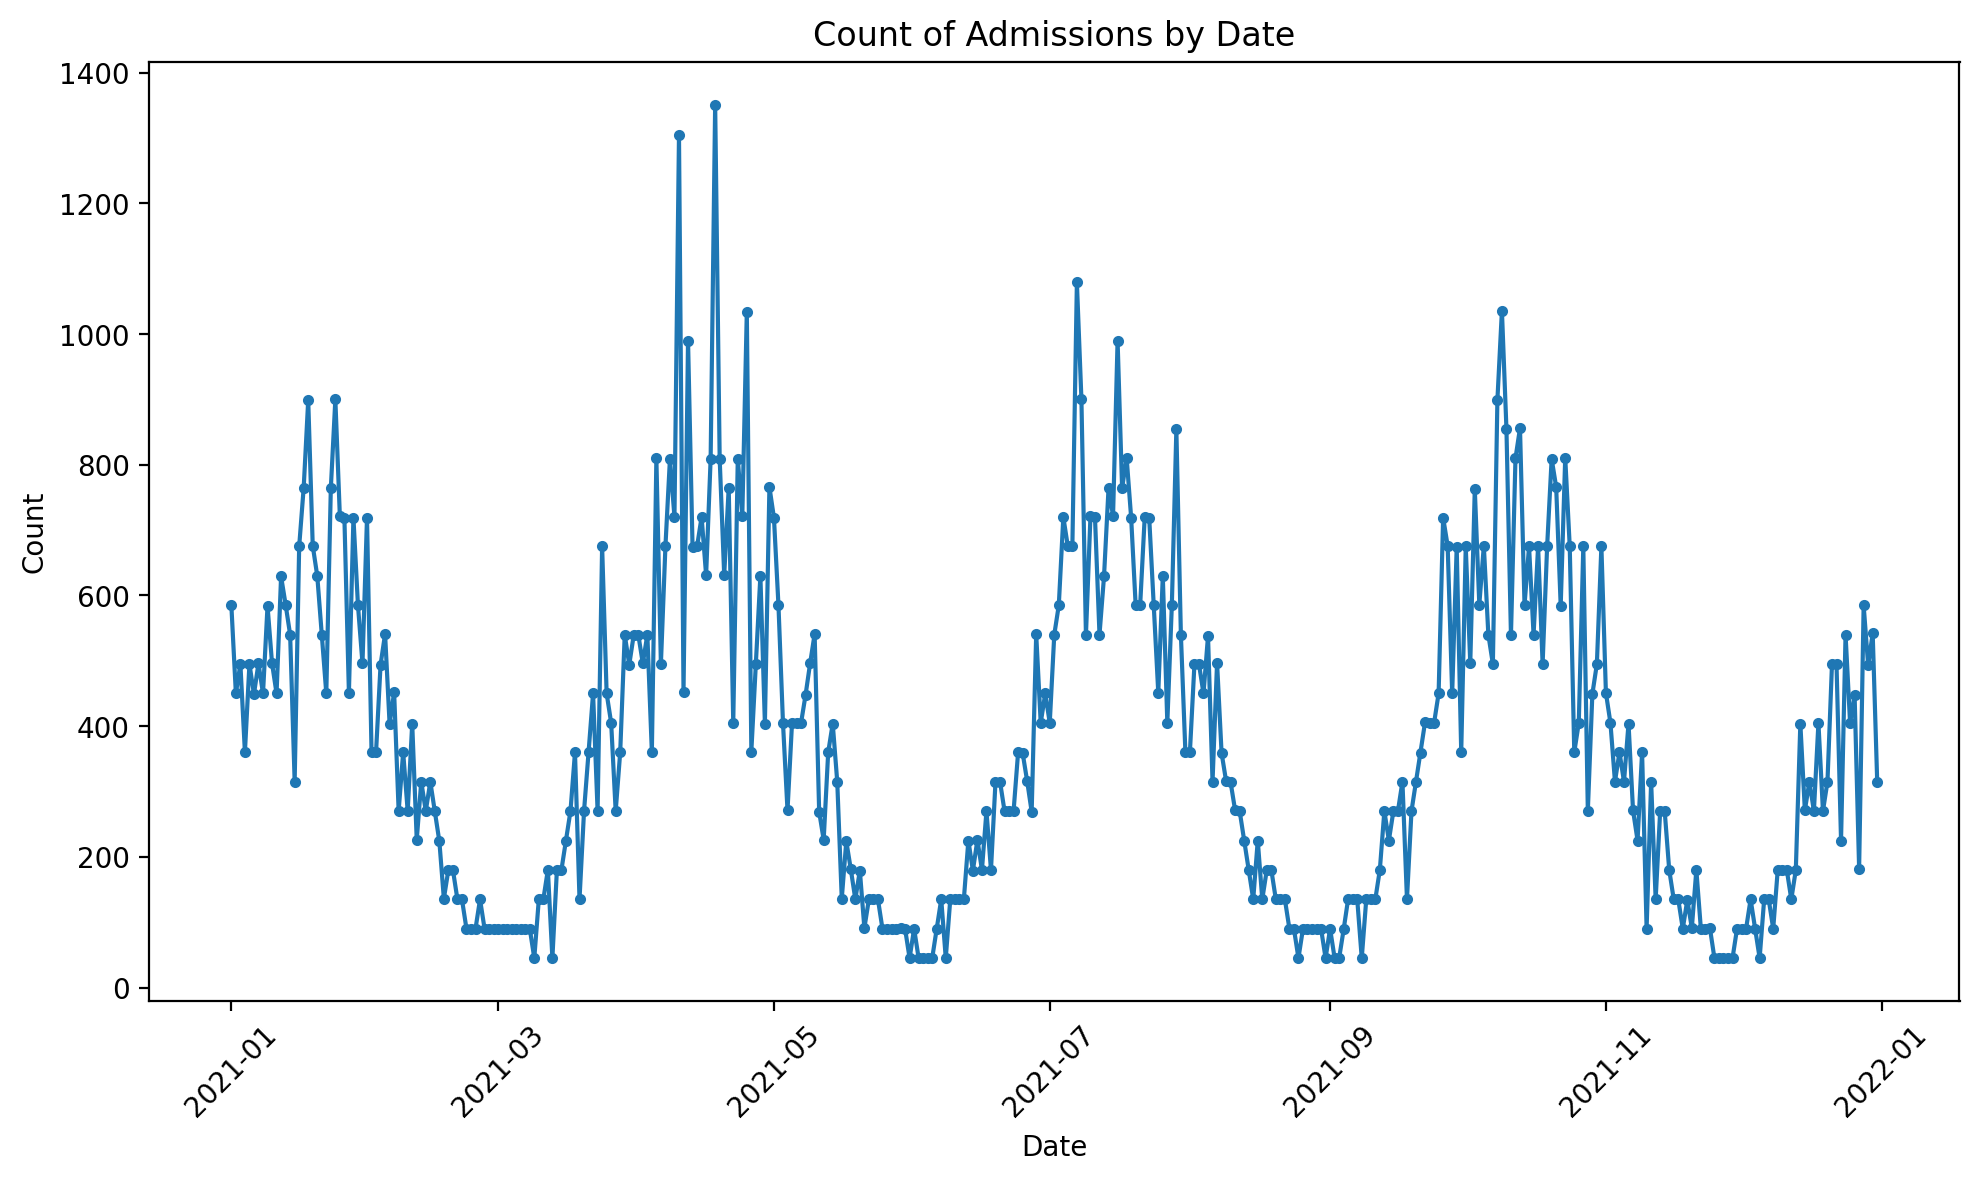

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
df_g=generated_data.Date_Time_Admission.dt.date.value_counts()#.reset_index()#.plot()
df_g.index = pd.to_datetime(df_g.index)
df_g = df_g.sort_index()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_g.index, df_g.values, marker='.', linestyle='-')
plt.title('Count of Admissions by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.grid(True)
plt.tight_layout()

In [80]:
generated_data.to_excel('Data\season_trend_data.xlsx',index=False)
generated_data.shape

(138375, 8)